In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import kruskal
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid", font_scale=2.5)

### RQ1: What is the amount of search engine moderation on Google vs Baidu?

4 classes:
- consistent suggestion
- unresponded query
- no group in the suggestion
- changed format in the suggestion

1) Show top-10 groups consistent suggestions
2) 3 barplots for each of the other group

In [41]:
# Differences between template

In [70]:
# Read in the data
baidu = pd.read_csv("data/baidu.csv")
# baidu = baidu[baidu["template_match"] == "template 2"]
google = pd.read_csv("data/google.csv")

In [71]:
baidu['suggestion_starts_with_query'].fillna(False, inplace=True)
google['suggestion_starts_with_query'].fillna(False, inplace=True)
baidu_start_with_query = baidu[baidu['suggestion_starts_with_query']]
google_start_with_query = google[google['suggestion_starts_with_query']]
# remove duplicated data in the same group
baidu_start_with_query = baidu_start_with_query.drop_duplicates(subset=['group_English', 'completion'])
google_start_with_query = google_start_with_query.drop_duplicates(subset=['group', 'completion'])

In [77]:
baidu.drop_duplicates(subset=['group_English', 'completion'])['category'].value_counts()

Nationalities         604
Peoples               333
Gender                320
Lifestyle             126
Age                   112
Political              71
Religion               71
Sexual Orientation     22
Name: category, dtype: int64

In [83]:
# Count occurrences of each group in both datasets
baidu_group_counts = baidu_start_with_query['group_English'].value_counts()
google_group_counts = google_start_with_query['group'].value_counts()
K = 10
# Get the top 10 groups for each dataset
top_K_baidu = baidu_group_counts.head(K)
top_K_google = google_group_counts.head(K)

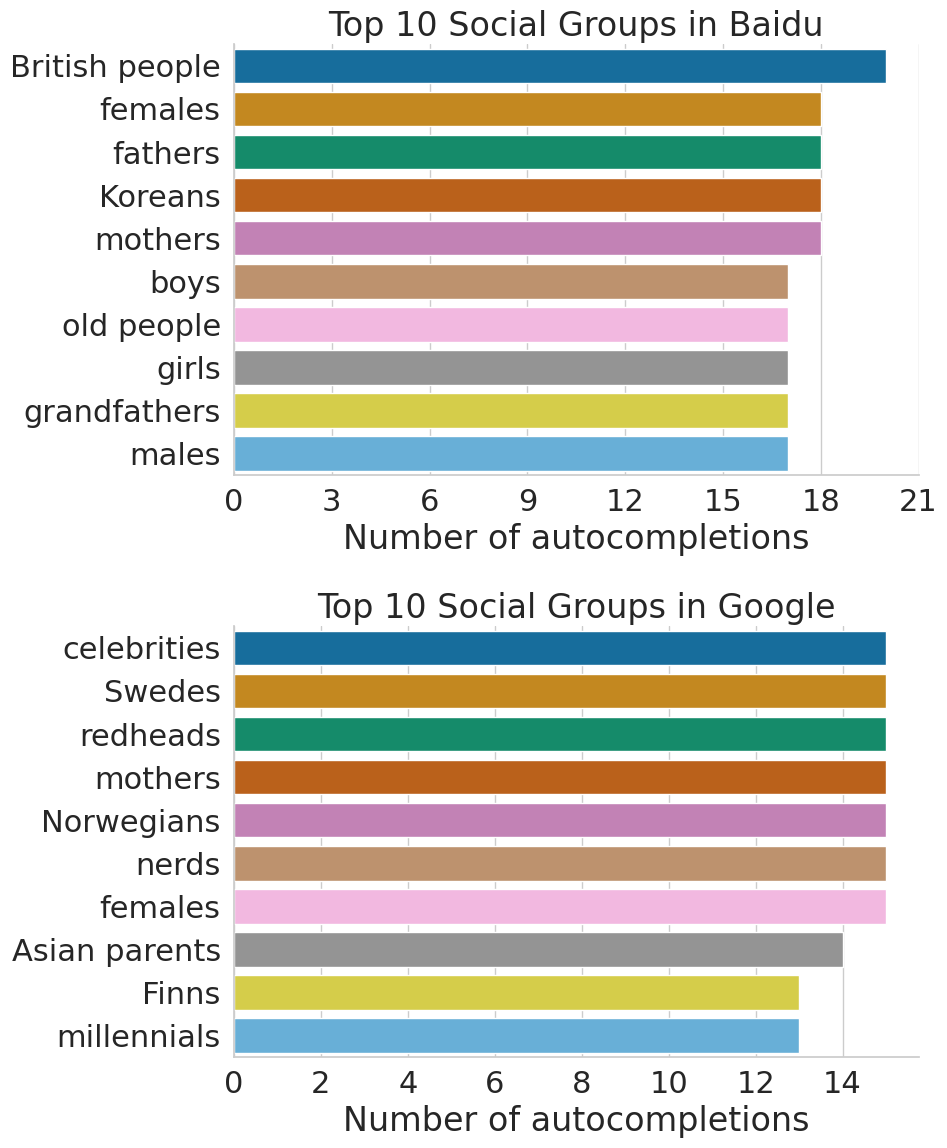

In [87]:
# Revised function to create a more refined and flatter horizontal bar plot without borders
def create_refined_horizontal_bar_plot(data, title, ax):
    sns.barplot(x=data.values, y=data.index, palette=sns.color_palette("colorblind"), ax=ax)
    ax.set_title(title)
    ax.set_ylabel("")
    ax.set_xlabel('Number of autocompletions')
    ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    sns.despine(ax=ax)  # Remove the top and right spines

# Create figure with two subplots for horizontal layout, adjusted for a flatter look
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))  # Adjusted size for a flatter appearance

# Plotting for Baidu
create_refined_horizontal_bar_plot(top_K_baidu, 'Top 10 Social Groups in Baidu', axes[0])

# Plotting for Google

create_refined_horizontal_bar_plot(top_K_google, 'Top 10 Social Groups in Google', axes[1])

plt.tight_layout()
plt.show()

fig.savefig("top_social_groups.pdf")

### unresponded query

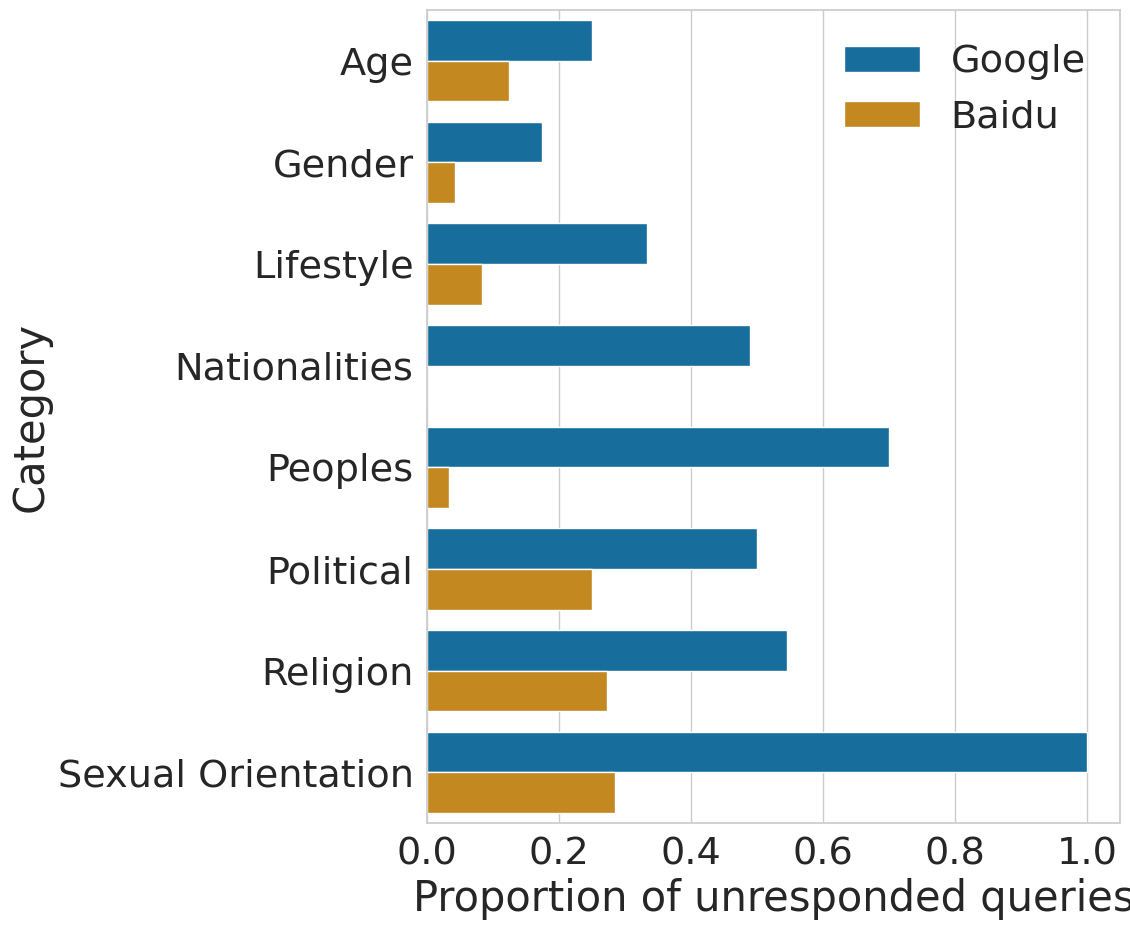

In [191]:
# Read in the data
baidu = pd.read_csv("data/baidu.csv").drop_duplicates(subset=['group_English'])
google = pd.read_csv("data/google.csv")

# Identifying unresponded queries for Google
unresponded_queries_google = google[google['suggestion'].isnull()]

# Identifying unresponded queries for Baidu 'Template 1'
# df_template_1 = baidu[baidu.template_match == "template 1"]
#unresponded_queries_baidu_template_1 = df_template_1[df_template_1['suggestion'].isna()]
unresponded_queries_baidu = baidu[baidu["suggestion"].isna()]

# Calculating unresponded rates for Google and Baidu
def calculate_unresponded_rates(df, unresponded_df):
    unique_queries_per_category = df.groupby('category')['query'].nunique()
    unresponded_queries_per_category = unresponded_df.groupby('category').size()
    unresponded_rate_per_category = (unresponded_queries_per_category / unique_queries_per_category).fillna(0)
    return pd.DataFrame({
        'Total Unique Queries': unique_queries_per_category,
        'Unresponded Queries': unresponded_queries_per_category,
        'Unresponded Rate': unresponded_rate_per_category
    }).reset_index()

# Google and Baidu unresponded rates DataFrames
google_unresponded_rate_df = calculate_unresponded_rates(google, unresponded_queries_google)
baidu_unresponded_rate_df = calculate_unresponded_rates(baidu, unresponded_queries_baidu)

# Preparing the data for seaborn plot
google_unresponded_rate_df['Search Engine'] = 'Google'
baidu_unresponded_rate_df['Search Engine'] = 'Baidu'
combined_df = pd.concat([google_unresponded_rate_df, baidu_unresponded_rate_df])

# Plotting using seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data=combined_df, x='Unresponded Rate', y='category', hue='Search Engine', palette='colorblind')
# plt.title('Unresponded Rate by Category in Google and Baidu "Template 1" (Color Blind Friendly)', fontsize=14)
plt.xlabel('Proportion of unresponded queries')
plt.ylabel('Category')
plt.tight_layout()
plt.legend(frameon=False)

fig.savefig("unresponded_proportion.pdf")

### no group in the suggestion
### changed format in the suggestion

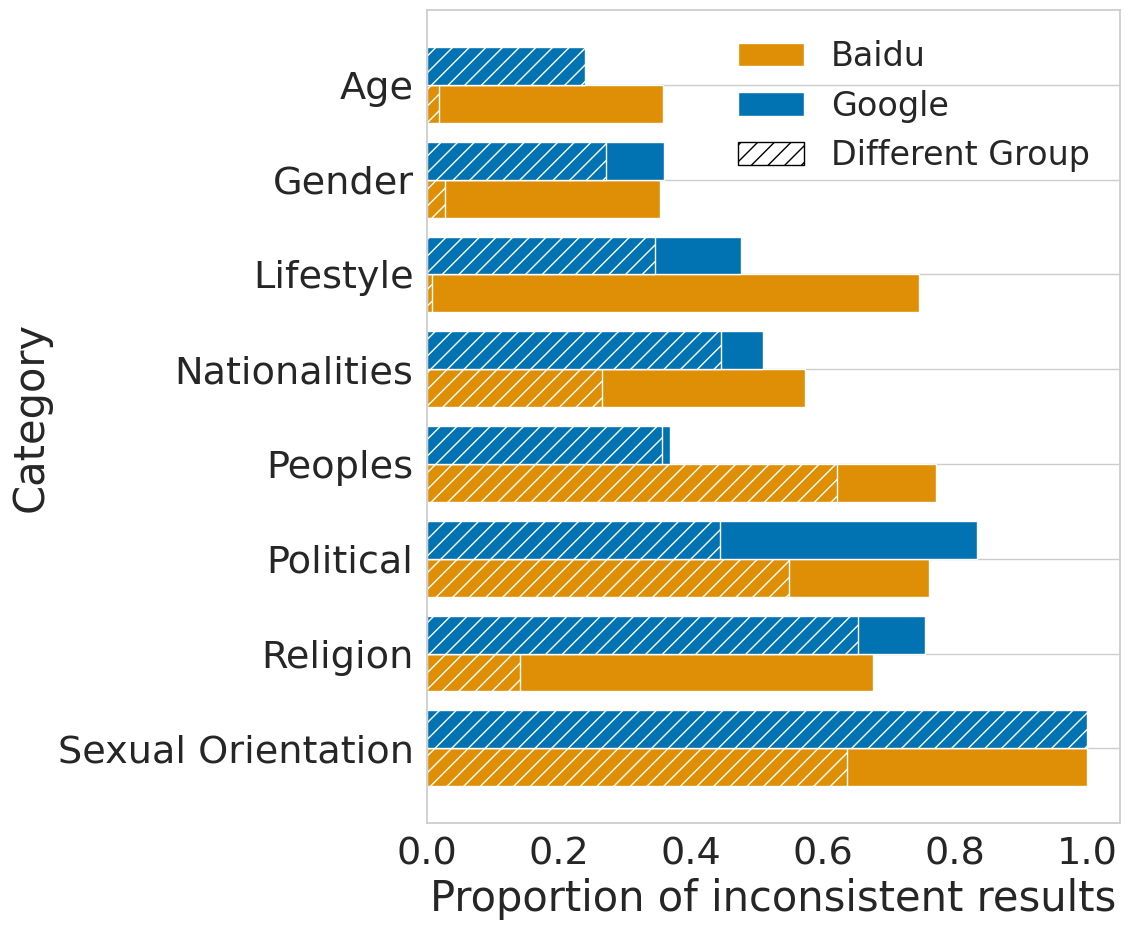

In [242]:
# Load the data
baidu = pd.read_csv("data/baidu.csv").drop_duplicates(subset=["completion",'group_English'])
google = pd.read_csv("data/google.csv")

# Define the function to calculate inverse proportions
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_suggestion'].sum()) / total
        proportions[category] = {'Not Follow Query': not_follow_query, 'Not Contain Group': not_contain_group}
    return proportions

# Group the data by category
grouped_baidu = baidu.groupby("category")
grouped_google = google.groupby('category')

# Calculate the inverse proportions
inverse_proportions_baidu = calculate_category_inverse_proportions(grouped_baidu)
inverse_proportions_google = calculate_category_inverse_proportions(grouped_google)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu',
        'Not Follow Query %': inverse_proportions_baidu[category]['Not Follow Query'],
        'Not Contain Group %': inverse_proportions_baidu[category]['Not Contain Group']
    })

for category in inverse_proportions_google:
    plot_data.append({
        'Category': category,
        'Template': 'Google',
        'Not Follow Query %': inverse_proportions_google[category]['Not Follow Query'],
        'Not Contain Group %': inverse_proportions_google[category]['Not Contain Group']
    })

df_plot_stacked_correct = pd.DataFrame(plot_data)
df_plot_stacked_correct = df_plot_stacked_correct.sort_values("Category", ascending=False)

# Set up for plotting
categories = df_plot_stacked_correct['Category'].unique()
templates = df_plot_stacked_correct['Template'].unique()
bar_width = 0.8
colors = sns.color_palette("colorblind")[:2][::-1]
index = np.arange(len(categories))

# Creating the plot with clear distinctions
plt.figure(figsize=(12, 10))
ax = plt.gca()

for i, template in enumerate(templates):
    # Adjusting the bar positions
    bar_positions = index - bar_width/4 + i * bar_width/2

    # Selecting data for each template
    template_data = df_plot_stacked_correct[df_plot_stacked_correct['Template'] == template]

    # Plotting the total 'Not Follow Query %'
    ax.barh(bar_positions, template_data['Not Follow Query %'], bar_width / 2, color=colors[i], label=f'{template}')

    # Plotting the 'Not Contain Group %' with a hatch pattern
    ax.barh(bar_positions, template_data['Not Contain Group %'], bar_width / 2, hatch='//', color=colors[i])

# Customizing the plot
plt.xlabel('Proportion of inconsistent results')
plt.ylabel('Category')
plt.yticks(index, categories)

import matplotlib.patches as mpatches
hatch = mpatches.Patch(facecolor="white", edgecolor="black",alpha=1,hatch=r'//',label='Different Group')

# Setting up the legend
handles, labels = ax.get_legend_handles_labels()
legend_handles = [handles[0], handles[1], hatch]
# legend_labels = ['Google - Not Follow Query %', 'Baidu - Not Follow Query %', 'Google - Not Contain Group % (hatched)', 'Baidu - Not Contain Group % (hatched)']
ax.legend(handles=legend_handles, frameon=False, loc='upper right', fontsize=24)

ax.xaxis.grid(False)
plt.tight_layout()

plt.savefig("modified_suggestions.pdf")

In [244]:
baidu = pd.read_csv("data/baidu.csv").drop_duplicates(subset=["completion",'group_English'])
google = pd.read_csv("data/google.csv")

# Group the data by group

grouped_baidu = baidu[baidu["suggestion_starts_with_query"] == False]
grouped_baidu = grouped_baidu.groupby("group_English").count().sort_values("query", ascending=False)

grouped_google = google[google["suggestion_starts_with_query"] == False]
grouped_google = grouped_google.groupby("group").count().sort_values("query", ascending=False)

grouped_baidu.head(10)

grouped_google.head(10)

,query,suggestion,category,completion,suggestion_starts_with_query,group_in_suggestion,extracted_suggestion,sentiment_rating_completion,sentiment_rating_full_suggestion
group,,,,,,,,,
Buddhists,15,15,15,15,15,15,0,0,0
grandfathers,15,15,15,15,15,15,0,0,0
geeks,13,13,13,13,13,13,0,0,0
grandmothers,12,12,12,12,12,12,0,0,0
criminals,11,11,11,11,11,11,0,0,0
Ecuadorians,11,11,11,11,11,11,0,0,0
immigrants,10,10,10,10,10,10,0,0,0
punks,10,10,10,10,10,10,0,0,0
Scots,9,9,9,9,9,9,0,0,0


In [245]:
google[google.group == "Buddhists"]

,query,suggestion,category,group,completion,suggestion_starts_with_query,group_in_suggestion,extracted_suggestion,sentiment_rating_completion,sentiment_rating_full_suggestion
620,why are Buddhists so,why are some buddhist vegetarian,Religion,Buddhists,why are some buddhist vegetarian,False,False,NaN,NaN,NaN
621,why are Buddhists so,why are buddhist temples so ornate,Religion,Buddhists,why are buddhist temples so ornate,False,False,NaN,NaN,NaN
622,why are Buddhists so,why are buddhist monks so happy,Religion,Buddhists,why are buddhist monks so happy,False,False,NaN,NaN,NaN
623,why are Buddhists so,what are some buddhist holidays,Religion,Buddhists,what are some buddhist holidays,False,False,NaN,NaN,NaN
624,why are Buddhists so,what are some buddhist practices,Religion,Buddhists,what are some buddhist practices,False,False,NaN,NaN,NaN
625,why are Buddhists so,what are some buddhist beliefs,Religion,Buddhists,what are some buddhist beliefs,False,False,NaN,NaN,NaN
626,why are Buddhists so,what are some buddhist traditions,Religion,Buddhists,what are some buddhist traditions,False,False,NaN,NaN,NaN
627,why are Buddhists so,what are some buddhist symbols,Religion,Buddhists,what are some buddhist symbols,False,False,NaN,NaN,NaN
628,why are Buddhists so,what are some buddhist festivals,Religion,Buddhists,what are some buddhist festivals,False,False,NaN,NaN,NaN
629,why are Buddhists so,what are some buddhist chants,Religion,Buddhists,what are some buddhist chants,False,False,NaN,NaN,NaN


# RQ2: What is the sentiment of search engine completion on Google vs Baidu?

In [48]:
## dataframe {engine, category, group, % negative}

## sns.boxplot
## hue = engine
## x = category
## y = % negative

## kruskal-wallis test?

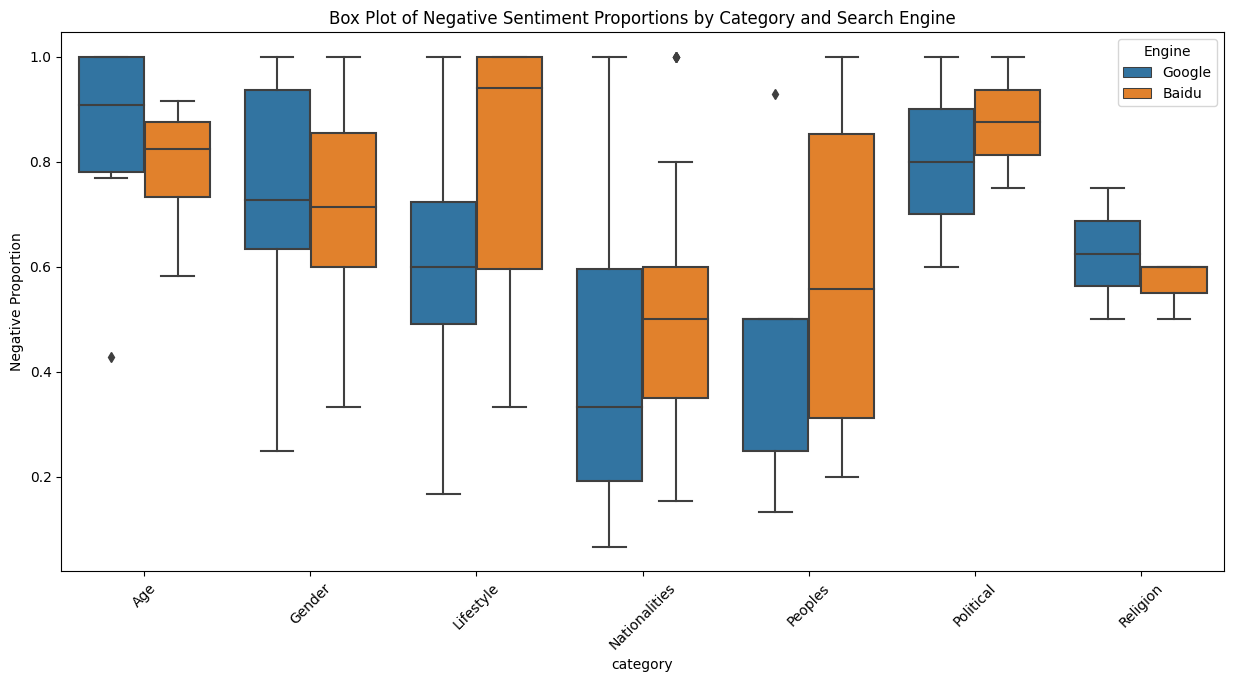

In [49]:
# Reading the files
google = pd.read_csv('data/google.csv')
baidu = pd.read_csv('data/baidu.csv')

baidu['suggestion_starts_with_query'].fillna(False, inplace=True)
google['suggestion_starts_with_query'].fillna(False, inplace=True)
baidu_start_with_query = baidu[baidu['suggestion_starts_with_query']]
google_start_with_query = google[google['suggestion_starts_with_query']]
# remove duplicated data in the same group
baidu_start_with_query = baidu_start_with_query.drop_duplicates(subset=['group_English', 'completion'])
google_start_with_query = google_start_with_query.drop_duplicates(subset=['group', 'completion'])
# Calculating the negative proportion for all groups in both datasets
google_negative_proportions_all = google_start_with_query[google_start_with_query['sentiment_rating_completion'] == 'Negative'].groupby(['category', 'group']).size() / google_start_with_query.groupby(['category', 'group']).size()
baidu_negative_proportions_all = baidu_start_with_query [baidu_start_with_query ['sentiment_rating_completion'] == 'Negative'].groupby(['category', 'group_English']).size() / baidu_start_with_query.groupby(['category', 'group_English']).size()

# Resetting index to convert Series to DataFrame for plotting
google_negative_proportions_df = google_negative_proportions_all.reset_index(name='Negative Proportion')
baidu_negative_proportions_df = baidu_negative_proportions_all.reset_index(name='Negative Proportion')

# Renaming columns for Baidu data to match Google data
baidu_negative_proportions_df.rename(columns={'group_English': 'group'}, inplace=True)

# Adding a column to distinguish between Google and Baidu data
google_negative_proportions_df['Engine'] = 'Google'
baidu_negative_proportions_df['Engine'] = 'Baidu'

# Concatenating both dataframes
combined_data = pd.concat([google_negative_proportions_df, baidu_negative_proportions_df])

# Plotting the combined box plot with hue based on search engine
plt.figure(figsize=(15, 7))
sns.boxplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
plt.title('Box Plot of Negative Sentiment Proportions by Category and Search Engine')
plt.xticks(rotation=45)
plt.show()


### kruskal-wallis test

In [50]:
# Filtering the data to include only the rows where there is a recorded negative proportion
filtered_google_data = google_negative_proportions_df[google_negative_proportions_df['Negative Proportion'].notna()]
filtered_baidu_data = baidu_negative_proportions_df[baidu_negative_proportions_df['Negative Proportion'].notna()]

# Performing the Kruskal-Wallis test for each category
categories = combined_data['category'].unique()
kruskal_results = {}

for category in categories:
    google_data_cat = filtered_google_data[filtered_google_data['category'] == category]['Negative Proportion']
    baidu_data_cat = filtered_baidu_data[filtered_baidu_data['category'] == category]['Negative Proportion']
    
    # Perform Kruskal-Wallis test if both Google and Baidu have data for the category
    if not google_data_cat.empty and not baidu_data_cat.empty:
        stat, p = kruskal(google_data_cat, baidu_data_cat)
        kruskal_results[category] = {'statistic': stat, 'p-value': p}

kruskal_results

{'Age': {'statistic': 0.5432098765432152, 'p-value': 0.46110548552542374},
 'Gender': {'statistic': 0.08829329259825308, 'p-value': 0.7663581973172011},
 'Lifestyle': {'statistic': 1.3834459459459474,
  'p-value': 0.23951504841271173},
 'Nationalities': {'statistic': 1.8206068354420293,
  'p-value': 0.1772410604486706},
 'Peoples': {'statistic': 0.26395027624309675, 'p-value': 0.6074191583640334},
 'Political': {'statistic': 0.16666666666666508,
  'p-value': 0.6830913983096101},
 'Religion': {'statistic': 0.09259259259259127, 'p-value': 0.7609067270751158}}

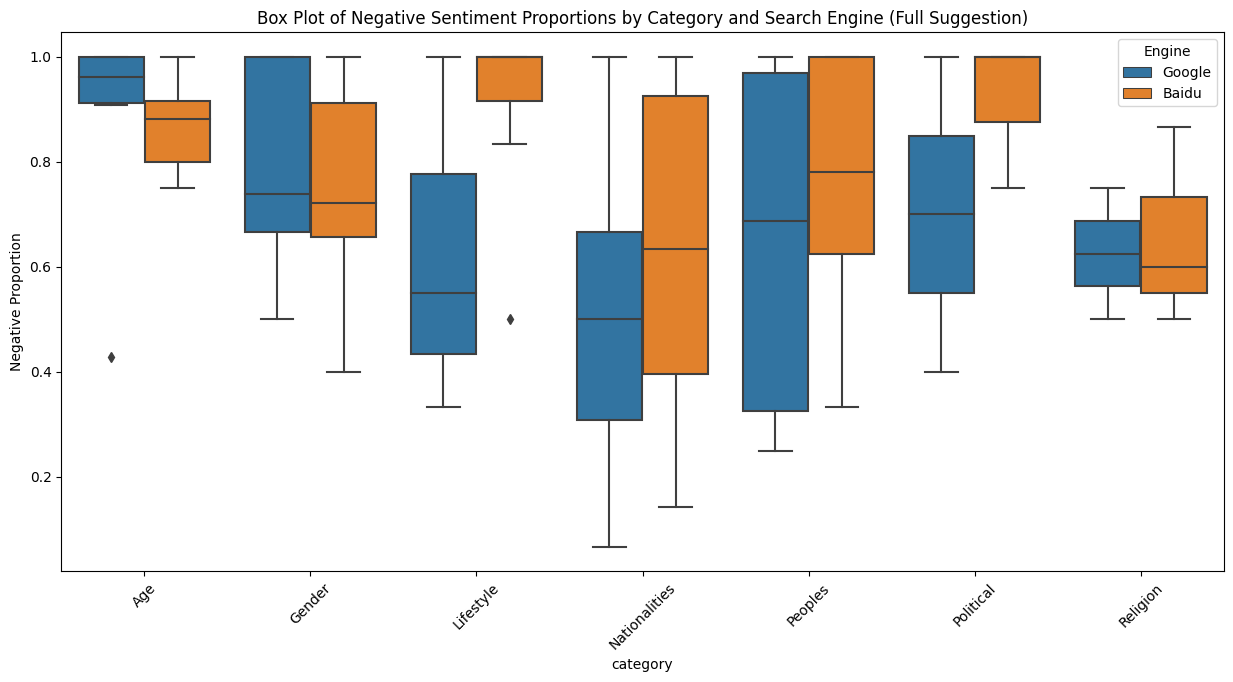

{'Age': {'statistic': 1.0563492063492133, 'p-value': 0.3040493256791847},
 'Gender': {'statistic': 0.2912673341543157, 'p-value': 0.5894095351179598},
 'Lifestyle': {'statistic': 5.176864244741869, 'p-value': 0.02288959733750166},
 'Nationalities': {'statistic': 2.5814922226173476,
  'p-value': 0.10811969282426268},
 'Peoples': {'statistic': 0.35383064516128887, 'p-value': 0.5519526636899947},
 'Political': {'statistic': 0.4166666666666696, 'p-value': 0.5186050164287239},
 'Religion': {'statistic': 0.0877192982456128, 'p-value': 0.7670968684102789}}

In [51]:



# Filtering the data for the 'Sentiment Rating (Full Suggestion)' column
google_full_suggestion_negative = google_start_with_query[google_start_with_query['sentiment_rating_full_suggestion'] == 'Negative'].groupby(['category', 'group']).size() / google_start_with_query.groupby(['category', 'group']).size()
baidu_full_suggestion_negative = baidu_start_with_query[baidu_start_with_query['sentiment_rating_full_suggestion'] == 'Negative'].groupby(['category', 'group_English']).size() / baidu_start_with_query.groupby(['category', 'group_English']).size()

# Resetting index to convert Series to DataFrame for plotting
google_full_suggestion_negative_df = google_full_suggestion_negative.reset_index(name='Negative Proportion')
baidu_full_suggestion_negative_df = baidu_full_suggestion_negative.reset_index(name='Negative Proportion')

# Renaming columns for Baidu data to match Google data
baidu_full_suggestion_negative_df.rename(columns={'group_English': 'group'}, inplace=True)

# Adding a column to distinguish between Google and Baidu data
google_full_suggestion_negative_df['Engine'] = 'Google'
baidu_full_suggestion_negative_df['Engine'] = 'Baidu'

# Concatenating both dataframes
combined_full_suggestion_data = pd.concat([google_full_suggestion_negative_df, baidu_full_suggestion_negative_df])

# Plotting the combined box plot with hue based on search engine
plt.figure(figsize=(15, 7))
sns.boxplot(data=combined_full_suggestion_data, x='category', y='Negative Proportion', hue='Engine')
plt.title('Box Plot of Negative Sentiment Proportions by Category and Search Engine (Full Suggestion)')
plt.xticks(rotation=45)
plt.show()

# Preparing the data for Kruskal-Wallis test (Full Suggestion)
filtered_google_full_suggestion_data = google_full_suggestion_negative_df[google_full_suggestion_negative_df['Negative Proportion'].notna()]
filtered_baidu_full_suggestion_data = baidu_full_suggestion_negative_df[baidu_full_suggestion_negative_df['Negative Proportion'].notna()]

# Performing the Kruskal-Wallis test for each category (Full Suggestion)
kruskal_results_full_suggestion = {}

for category in categories:
    google_data_cat_full = filtered_google_full_suggestion_data[filtered_google_full_suggestion_data['category'] == category]['Negative Proportion']
    baidu_data_cat_full = filtered_baidu_full_suggestion_data[filtered_baidu_full_suggestion_data['category'] == category]['Negative Proportion']
    
    # Perform Kruskal-Wallis test if both Google and Baidu have data for the category
    if not google_data_cat_full.empty and not baidu_data_cat_full.empty:
        stat, p = kruskal(google_data_cat_full, baidu_data_cat_full)
        kruskal_results_full_suggestion[category] = {'statistic': stat, 'p-value': p}

kruskal_results_full_suggestion

